#  Minimum Spanning Tree Problem 
## Complete Subtour Elimination Constraints (SEC) formulation  

This formulation contains all SEC inequalities.
See slides **Network Optimization Part III.pdf** for details


In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt


from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display



## Drawing functions

In [2]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [4]:
class args:
    filename = None
    scale = 40

args.filename = "graph30_1.gml"
args.figsize = 30,30

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


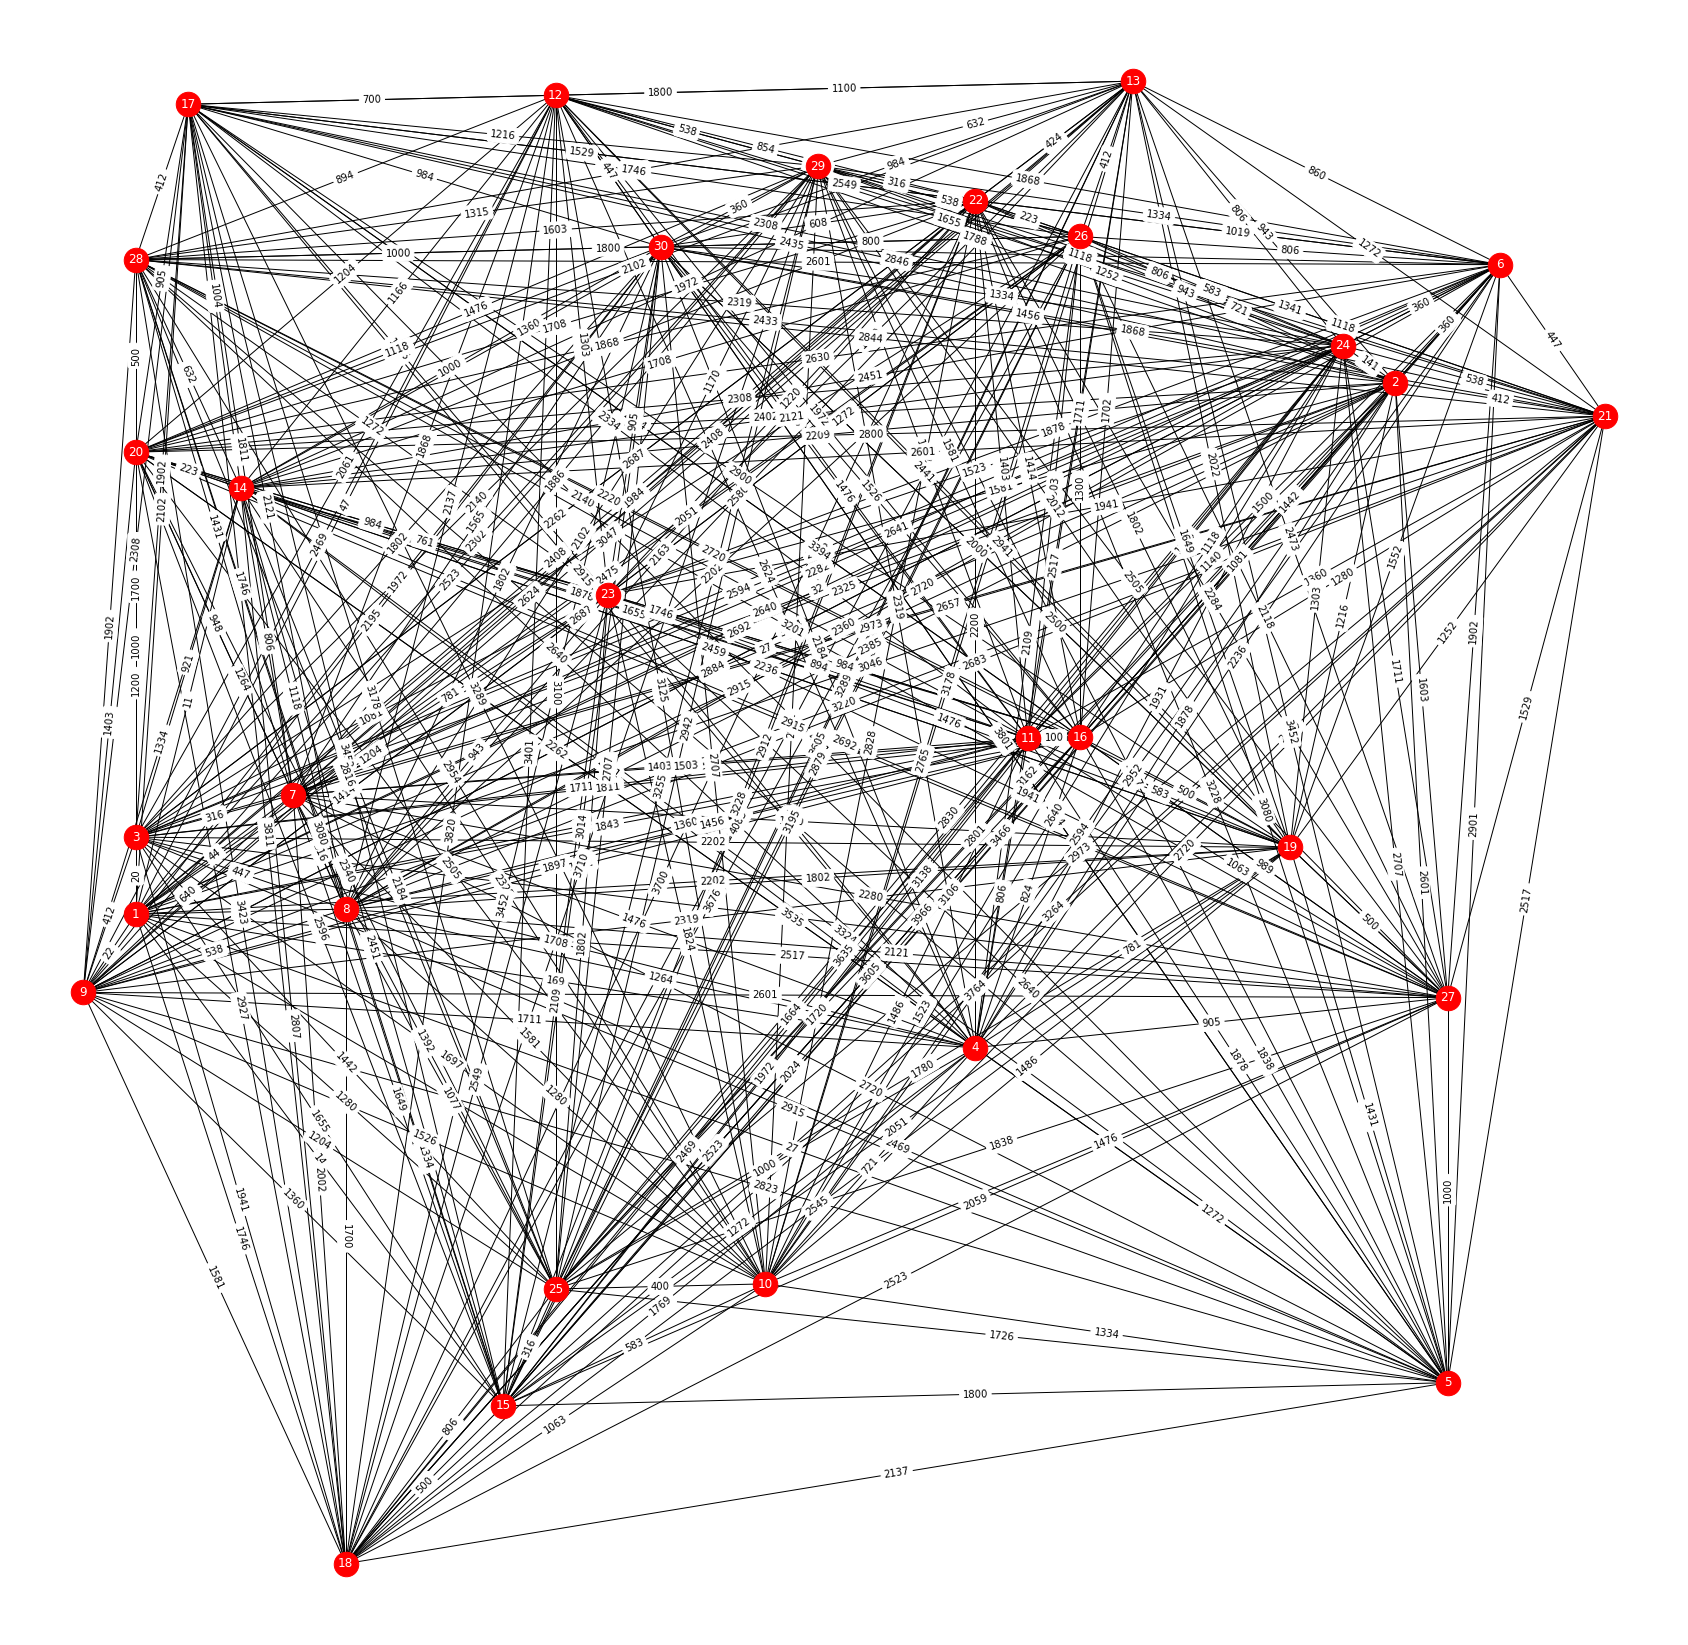

In [5]:
DrawInitG(G, withedges=True)

In [6]:
def DrawSolCallback(G, x):
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    plt.figure(figsize=args.figsize)
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v] > 0.1]

    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_in_sol, connectionstyle='arc3,rad=0.2')
    plt.axis('off')
    plt.show()

In [8]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(),\
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.BINARY, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

###########################
# Root degree constraint  # 
###########################

root = 1
rootdeg = 3

mst.addConstr(gb.quicksum([x[u,v] if (u,v) in x else x[v,u] for u,v in G.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')



mst.update()

mst.write('mst.lp')

In [9]:
mst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 435 columns and 464 nonzeros
Model fingerprint: 0x9a6dacd6
Variable types: 0 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+01]
Found heuristic solution: objective 52674.000000
Presolve removed 0 rows and 395 columns
Presolve time: 0.00s
Presolved: 2 rows, 40 columns, 68 nonzeros
Found heuristic solution: objective 9960.0000000
Variable types: 0 continuous, 40 integer (32 binary)

Root relaxation: cutoff, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      9960.00000 9960.00000  0.00%     -    0s

Explored 0 nodes (2 simplex i

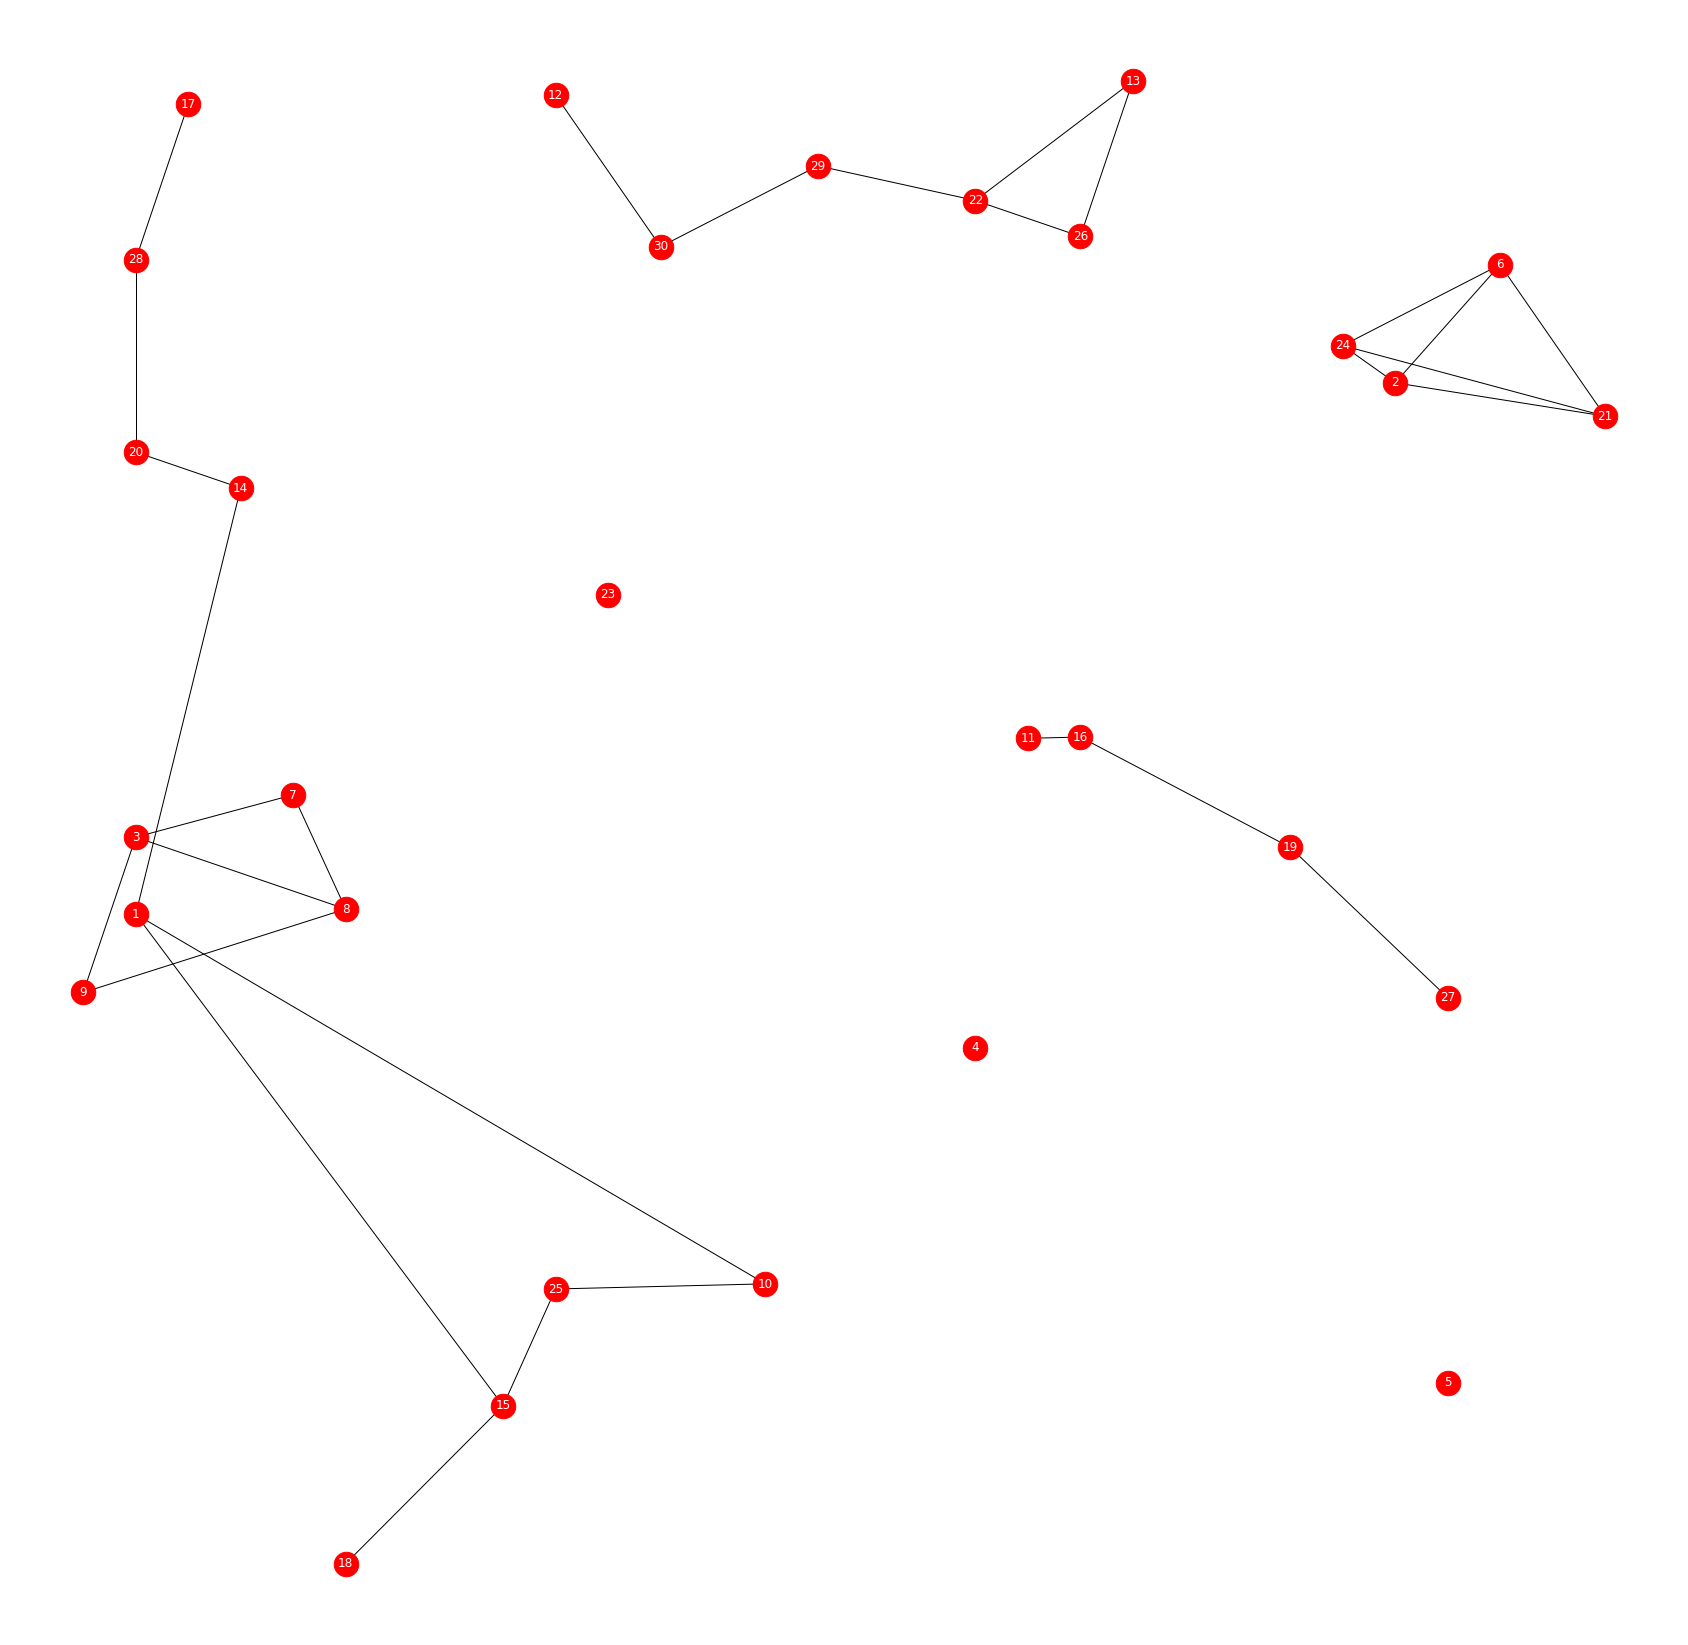

In [10]:
DrawSol(G,x)


## Data needed to the callback

Our callback needs: 
   1. The graph $G$
   2. The variables $x$
   3. The separation routine
   4. The number of SECs generated so far
 
The above data are added to the ``mst`` Model. Note the ``_`` before the data name

In [11]:
mst._graph = G
mst._vars = x
mst._nSEC = 0



In [12]:
import math
import itertools

def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        x_at_node = model.cbGetSolution(x)
        G = model._graph
                
        sol_G = G.edge_subgraph([(u,v) for (u,v) in G.edges() 
                                 if math.isclose(x_at_node[u,v], 1.0, abs_tol=1E-3)])
        
        #
        # Check if sol_G is connected
        #
        
        # DrawSolCallback(G, x_at_node)
        
        for cc in nx.connected_components(sol_G):

            if len(cc) < G.number_of_nodes():
                if len(cc) > 2:
                    if sol_G.subgraph(cc).number_of_edges() > (len(cc) - 1):
                        
                        seclhs = gb.quicksum(x[u,v] if (u,v) in x else x[v,u] 
                                             for u,v in G.subgraph(cc).edges())
                        
                        model.cbLazy(seclhs <= len(cc) - 1)
                        model._nSEC += 1

                        print (f"SEC --> {G.subgraph(cc).nodes()}")
        print ('_'*50)

                

In [13]:
mst.reset()
mst.Params.OutputFlag = 1
mst.Params.lazyConstraints = 1
mst.optimize(SECcallback)



Discarded solution information
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 435 columns and 464 nonzeros
Model fingerprint: 0x9a6dacd6
Variable types: 0 continuous, 435 integer (435 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+01]
SEC --> [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
__________________________________________________
SEC --> [22, 23, 24, 25, 26, 27, 28, 29, 30]
__________________________________________________
Presolve time: 0.00s
Presolved: 2 rows, 435 columns, 464 nonzeros
Variable types: 0 continuous, 435 integer (435

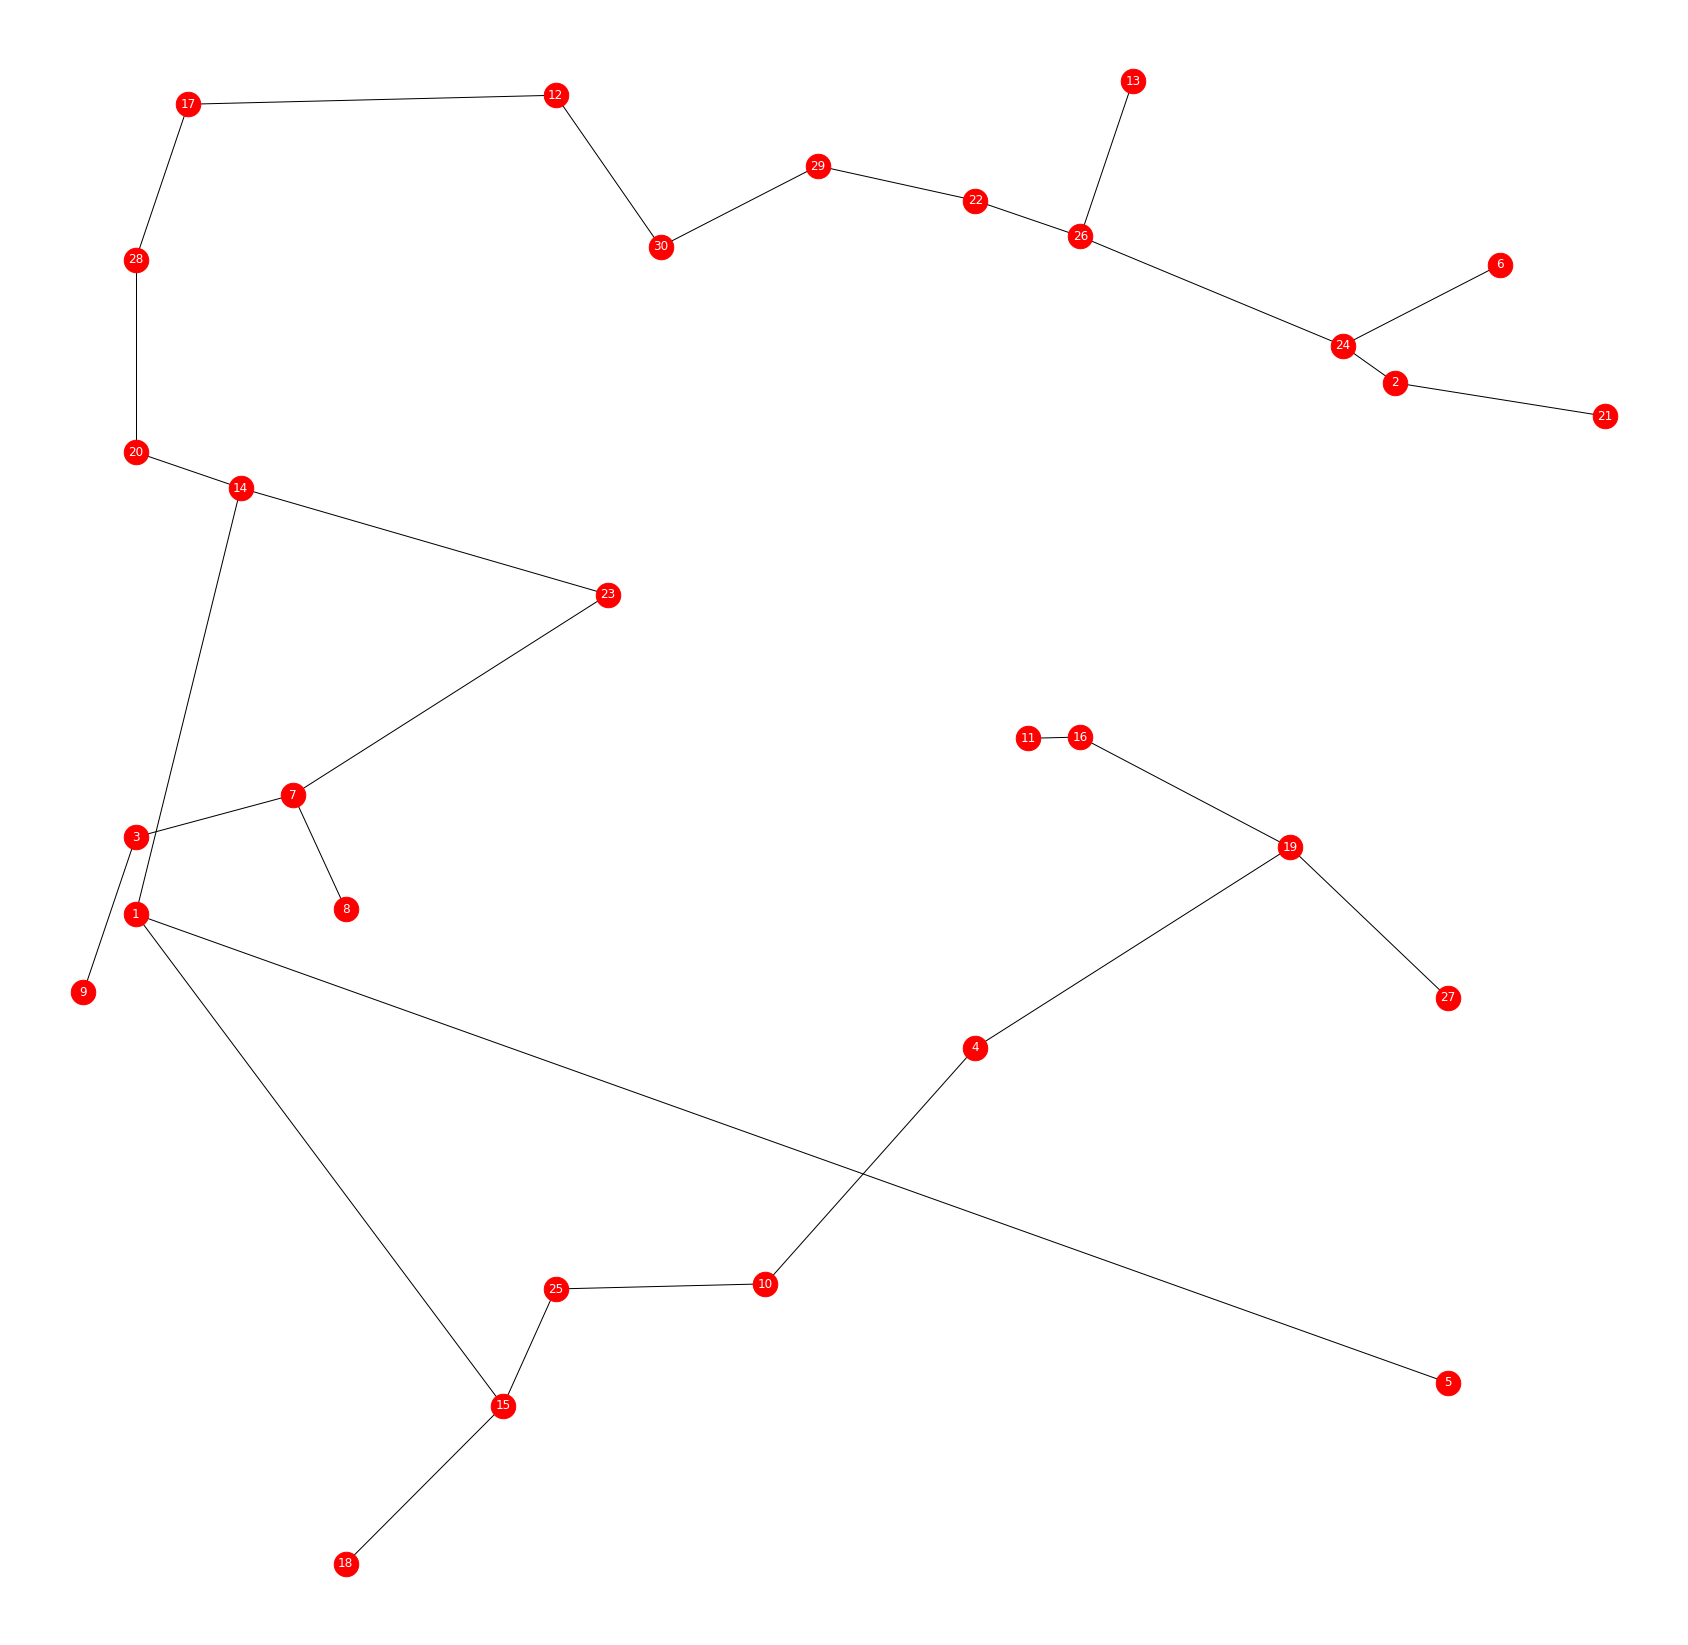

In [14]:
DrawSol(G, x)